## Tiltmeter - Resamle Check

### Import Libraries

In [1]:
%autosave 120

import os
import yaml
import matplotlib.pyplot as plt

from pandas import read_csv, DataFrame, date_range
from obspy import UTCDateTime, read, Stream
from numpy import nanmean 

from andbro__readYaml import __readYaml
from andbro__savefig import __savefig

from andbro__querrySeismoData import __querrySeismoData

Autosaving every 120 seconds


In [2]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/"
    data_path = "/home/andbro/kilauea-data/"
    archive_path = "/home/andbro/freenas/"
elif os.uname().nodename == "kilauea":
    root_path = "/home/brotzer/"
    data_path = "/import/kilauea-data/"
    archive_path = "/import/freenas-ffb-01-data/"

### Define Functions

In [3]:
def __makeplot(pt, bt, config):
    
    fig, axes = plt.subplots(3,2, figsize=(15,5), sharex=True)
    
    font = 14
    
    pt.sort()
    bt.sort()

    for i in range(3):
        
        axes[i,0].plot(pt[i].times(reftime=UTCDateTime("2019-01-01T00"))/3600, pt[i].data, label=pt[i].stats.channel)
        axes[i,1].plot(bt[i].times(reftime=UTCDateTime("2019-01-01T00"))/3600, bt[i].data, label=pt[i].stats.channel)
        
        axes[i,0].grid()
        axes[i,1].grid()
        
        axes[i,0].legend(loc=1)
        axes[i,1].legend(loc=1)
        
        axes[i,0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axes[i,1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    axes[2,0].ticklabel_format(axis="y", style="plain")
    axes[2,1].ticklabel_format(axis="y", style="plain")    
        
    axes[2,0].set_xlabel("Time (hours)", fontsize=font)
    axes[2,1].set_xlabel("Time (hours)", fontsize=font)
    
    axes[0,0].set_ylabel("E (rad)", fontsize=font)
    axes[1,0].set_ylabel("N (rad)", fontsize=font)
    axes[2,0].set_ylabel("Temp (°C)", fontsize=font)
    
    axes[0,0].set_title(f"{pt[0].stats.station}")
    axes[0,1].set_title(f"{bt[0].stats.station}")
    
    return fig 

In [4]:
def __conversion(st, conf):

    st0 = st.copy()
    
    def convertTemp(trace):
        Tvolt = trace.data * conf.get('gainTemp')
        coeff = conf.get('calcTempCoefficients')
        return coeff[0] + coeff[1]*Tvolt + coeff[2]*Tvolt**2 + coeff[3]*Tvolt**3
    
    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity

    for tr in st0:
        if tr.stats.channel[-1] == 'T':
            tr.data = convertTemp(tr)
        elif tr.stats.channel[-1] == 'N':
            tr.data = convertTilt(tr, conf['convTN'], conf['gainTilt'])
        elif tr.stats.channel[-1] == 'E':
            tr.data = convertTilt(tr, conf['convTE'], conf['gainTilt'])
        else:
            print("no match")
            
    print(f"  -> converted data of {st[0].stats.station}")
    return st0

In [5]:
def __smooth(y, box_pts):
    from numpy import ones, convolve, hanning

#     win = ones(box_pts)/box_pts
    win = hanning(box_pts)
    y_smooth = convolve(y, win/sum(win), mode='same')

    return y_smooth

### Configurations

In [6]:
## configurations
config={}

config['save'] = False

## get 'raw' data from romy archive
# config['datapath'] = f"{archive_path}/romy_archive"

## get downsampled data 
config['datapath'] = f"{data_path}TiltmeterDataBackup/Tilt_downsampled"

## time selection
config['tbeg'] = UTCDateTime("2022-04-24 00:00")
# config['tend'] = UTCDateTime("2022-05-31 00:00")
config['tend'] = UTCDateTime("2022-06-12 00:00")

## specify output directory for figures
config['output_figures'] = f"{root_path}Documents/ROMY/tiltmeter/figures/"

## indicate path to wromy data
config['pathToWromy'] = f"{data_path}wromy/"

## gain for Temperature channel of PT was not set correctly prior to 2021-03-03
correct_settings_temp_PT = ("2021-03-05", config['tend'])

## tiltmeter configurations
confTilt = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter.conf")

## correction of offset (e.g. reset mass)
offset_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter_steps.yml")

## correction for temperature trends
## based on MAT
temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","temperature_correction.yml")
## based on WSX
# temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","temperature_correction_new.yml")


### Load ROMY Saganac Frequency

In [7]:
def __load_data(config):
    
    from datetime import date
    from pandas import read_pickle, concat

    t1 = date.fromisoformat(str(config['tbeg'].date))
    t2 = date.fromisoformat(str(config['tend'].date))

    df = DataFrame()
    for dat in date_range(t1,t2):
        file = str(dat)[:10].replace("-","")+".pkl"
        try:
            df0 = read_pickle(config['datadir']+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")
            
    return df

In [8]:
config['datadir'] = "/import/kilauea-data/sagnac_frequency/hilbert_60_tilt/"

df1 = __load_data(config)
     
from numpy import where, nan, array
from obspy import Trace
df1['freqs'] = where(df1['psd_max'] > 1e5, df1['freqs'], nan)

beat = Trace()
beat.data = array(df1['freqs'])
beat.stats.starttime = config['tbeg']
beat.stats.sampling_rate = 1/60


### Load Tiltmeter Data

In [9]:
def __load_local(config, seed_id):
    
    from tqdm.notebook import tqdm
    from obspy.clients.filesystem.sds import Client
    
    net, sta, loc, cha = seed_id.split(".")
    
    tbeg, tend = config['tbeg'], config['tend']

    st0 = Client(config['datapath'],fileborder_samples=1000).get_waveforms(net, sta, loc, cha, tbeg, tend)
    
    st0.merge()
    
    return st0

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAT | 2022-04-24T00:00:00.039999Z - 2022-06-11T23:50:00.039999Z | 600.0 s, 7056 samples


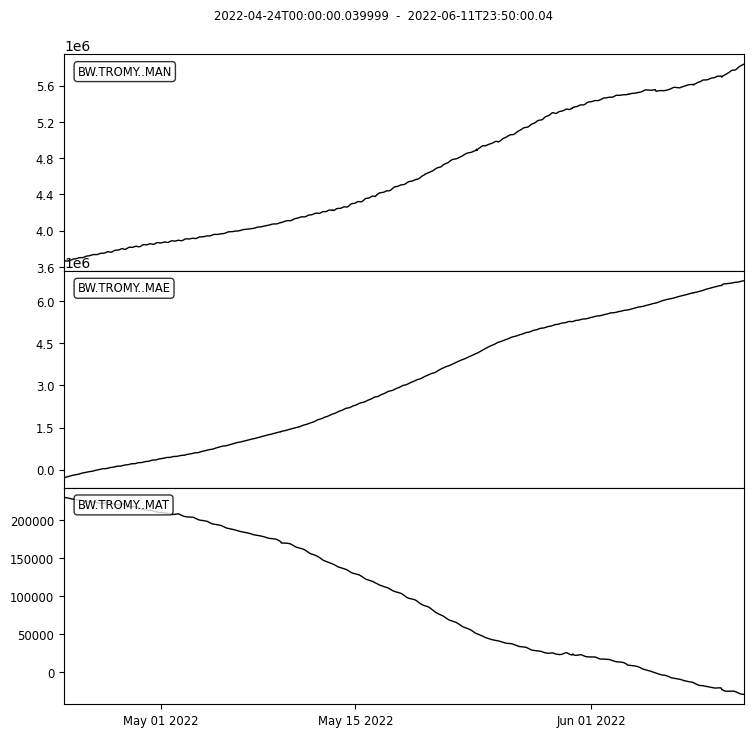

In [10]:
TROMY0 = __load_local(config, "BW.TROMY..MA*")

TROMY0.sort()
print(TROMY0)
TROMY0.plot(equal_scale=False);

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-12T00:00:00.040000Z | 5.0 Hz, 21168001 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-12T00:00:00.040000Z | 5.0 Hz, 21168001 samples
BW.TROMY..MAT | 2022-04-24T00:00:00.039999Z - 2022-06-12T00:00:00.039999Z | 5.0 Hz, 21168001 samples


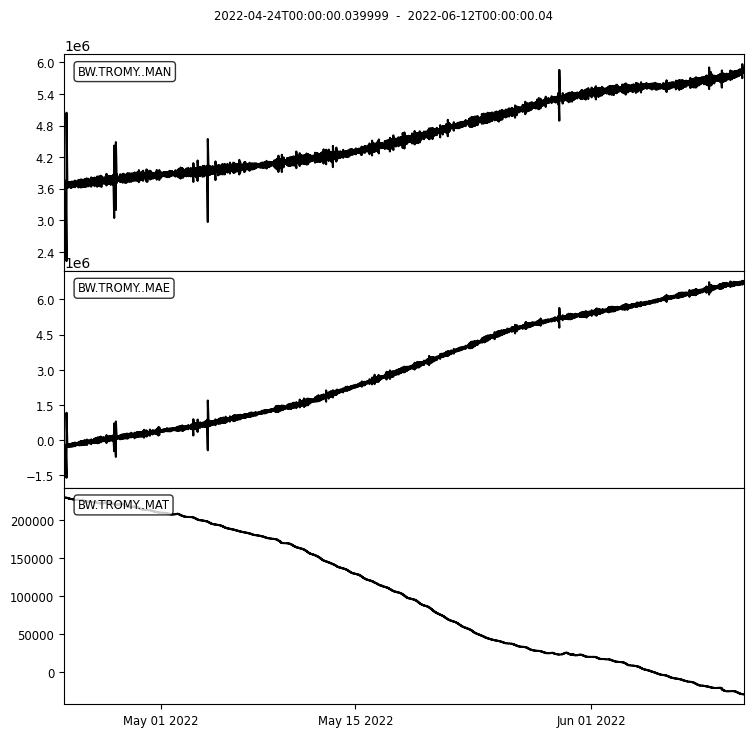

In [11]:
TROMY00, inv1 = __querrySeismoData(    
                                    seed_id="BW.TROMY..MA*",
                                    starttime=config.get("tbeg"),
                                    endtime=config.get("tend"),
                                    repository="george",
                                    path=None,
                                    restitute=True,
                                    detail=None,
                                    fill_value=-9999, 
                                    )

TROMY00.sort()
print(TROMY00)
TROMY00.plot(equal_scale=False);

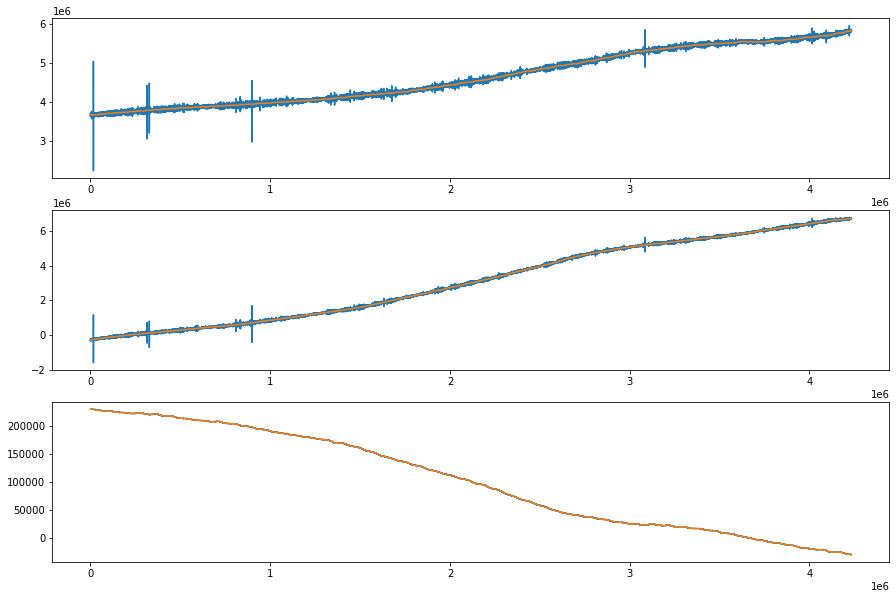

In [12]:
fig, ax = plt.subplots(3,1, figsize=(15,10))

ax[0].plot(TROMY00[0].times(), TROMY00.select(channel="MAN")[0].data)
ax[0].plot(TROMY0[0].times(), TROMY0.select(channel="MAN")[0].data)

ax[1].plot(TROMY00[0].times(), TROMY00.select(channel="MAE")[0].data)
ax[1].plot(TROMY0[0].times(), TROMY0.select(channel="MAE")[0].data)

ax[2].plot(TROMY00[0].times(), TROMY00.select(channel="MAT")[0].data)
ax[2].plot(TROMY0[0].times(), TROMY0.select(channel="MAT")[0].data)

plt.show();

In [14]:
TROMY00_fil = TROMY00.copy()
TROMY00_fil.detrend("linear")
TROMY00_fil.taper(0.01)
TROMY00_fil.filter("bandpass", freqmin=1e-8, freqmax=1/3/600, corners=4, zerophase=True)

TROMY0_fil = TROMY0.copy()
TROMY0_fil.detrend("linear")
TROMY0_fil.taper(0.01)
TROMY0_fil.filter("bandpass", freqmin=1e-8, freqmax=1/3/600, corners=4, zerophase=True)


3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-12T00:00:00.040000Z | 5.0 Hz, 21168001 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-12T00:00:00.040000Z | 5.0 Hz, 21168001 samples
BW.TROMY..MAT | 2022-04-24T00:00:00.039999Z - 2022-06-12T00:00:00.039999Z | 5.0 Hz, 21168001 samples

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-12T00:00:00.040000Z | 5.0 Hz, 21168001 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-12T00:00:00.040000Z | 5.0 Hz, 21168001 samples
BW.TROMY..MAT | 2022-04-24T00:00:00.039999Z - 2022-06-12T00:00:00.039999Z | 5.0 Hz, 21168001 samples

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-12T00:00:00.040000Z | 5.0 Hz, 21168001 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-12T00:00:00.040000Z | 5.0 Hz, 21168001 samples
BW.TROMY..MAT | 2022-04-24T00:00:00.039999Z - 2022-06-12T00:00:00.039999Z | 5.0 Hz, 21168001 samples

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAT | 2022-04-24T00:00:00.039999Z - 2022-06-11T23:50:00.039999Z | 600.0 s, 7056 samples

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAT | 2022-04-24T00:00:00.039999Z - 2022-06-11T23:50:00.039999Z | 600.0 s, 7056 samples

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAT | 2022-04-24T00:00:00.039999Z - 2022-06-11T23:50:00.039999Z | 600.0 s, 7056 samples

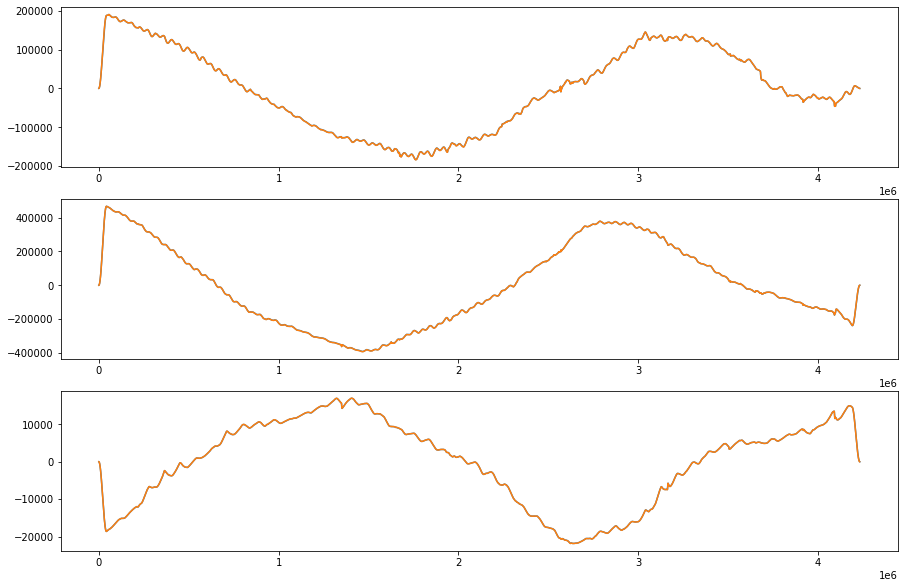

In [15]:
fig, ax = plt.subplots(3,1, figsize=(15,10))

ax[0].plot(TROMY00_fil[0].times(), TROMY00_fil.select(channel="MAN")[0].data)
ax[0].plot(TROMY0_fil[0].times(), TROMY0_fil.select(channel="MAN")[0].data)

ax[1].plot(TROMY00_fil[0].times(), TROMY00_fil.select(channel="MAE")[0].data)
ax[1].plot(TROMY0_fil[0].times(), TROMY0_fil.select(channel="MAE")[0].data)

ax[2].plot(TROMY00_fil[0].times(), TROMY00_fil.select(channel="MAT")[0].data)
ax[2].plot(TROMY0_fil[0].times(), TROMY0_fil.select(channel="MAT")[0].data)

plt.show();

In [33]:
TROMY00.copy().select(channel="MAT")[0].resample(1/600, no_filter=True)
TROMY0

BW.TROMY..MAT | 2022-04-24T00:00:00.039999Z - 2022-06-11T23:50:00.039999Z | 600.0 s, 7056 samples

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAT | 2022-04-24T00:00:00.039999Z - 2022-06-11T23:50:00.039999Z | 600.0 s, 7056 samples

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-12T00:00:00.040000Z | 5.0 Hz, 21168001 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-12T00:00:00.040000Z | 5.0 Hz, 21168001 samples
BW.TROMY..MAT | 2022-04-24T00:00:00.039999Z - 2022-06-12T00:00:00.039999Z | 5.0 Hz, 21168001 samples

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAT | 2022-04-24T00:00:00.039999Z - 2022-06-11T23:50:00.039999Z | 600.0 s, 7056 samples

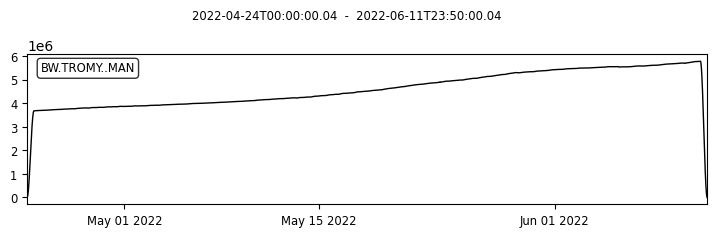

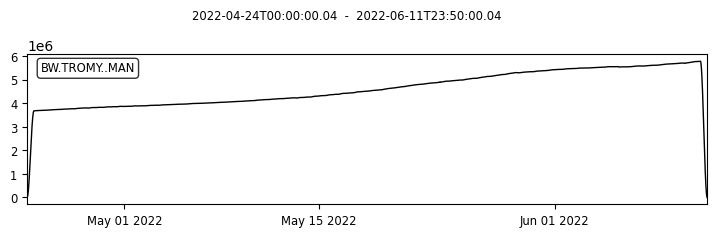

ValueError: operands could not be broadcast together with shapes (7056,) (35281,) 

In [60]:
TROMY00_res = TROMY00.copy()
TROMY00_res.taper(0.01)
TROMY00_res.resample(1/600, no_filter=True)
TROMY00_res.select(channel="MAN").plot();

diff = TROMY0.select(channel="MAN")[0].data - TROMY00.select(channel="MAN")[0].data[::600]


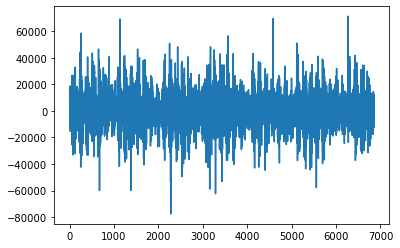

In [66]:
plt.plot(diff[100:-100])
# plt.ylim(0.5, -0.5)

3 Trace(s) in Stream:
BW.ROMYT..MAE | 2022-04-24T00:09:59.940000Z - 2022-06-11T23:59:59.940000Z | 600.0 s, 7056 samples
BW.ROMYT..MAN | 2022-04-24T00:09:59.940000Z - 2022-06-11T23:59:59.940000Z | 600.0 s, 7056 samples
BW.ROMYT..MAT | 2022-04-24T00:09:59.940000Z - 2022-06-11T23:59:59.940000Z | 600.0 s, 7056 samples


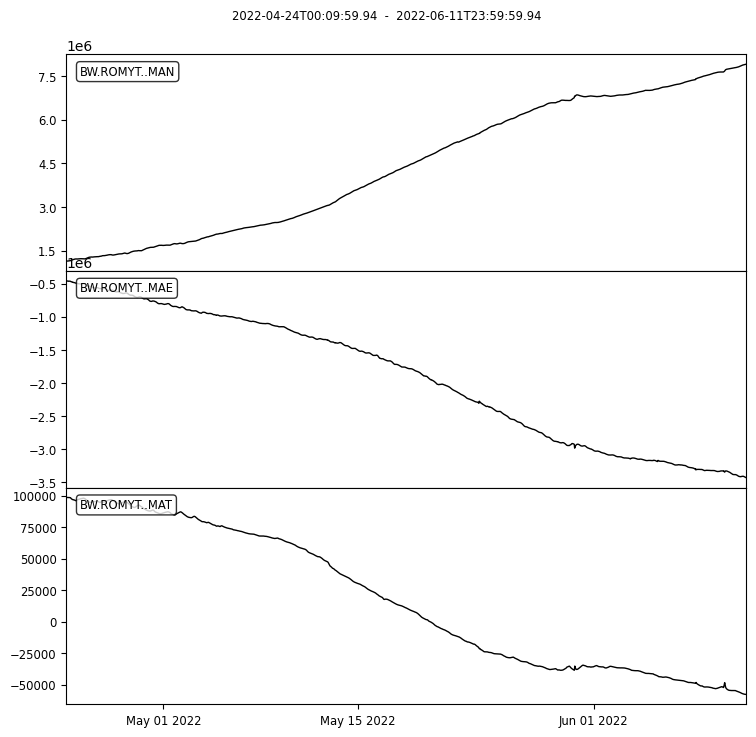

In [39]:
ROMYT0 = __load_local(config, "BW.ROMYT..MA*")
ROMYT0.sort()
print(ROMYT0)
ROMYT0.plot(equal_scale=False);

3 Trace(s) in Stream:
BW.DROMY..LAE | 2022-04-24T00:00:00.000000Z - 2022-06-12T00:00:00.000000Z | 600.0 s, 7057 samples (masked)
BW.DROMY..LAN | 2022-04-24T00:00:00.000000Z - 2022-06-12T00:00:00.000000Z | 600.0 s, 7057 samples (masked)
BW.DROMY..LAT | 2022-04-24T00:00:00.000000Z - 2022-06-12T00:00:00.000000Z | 600.0 s, 7057 samples (masked)


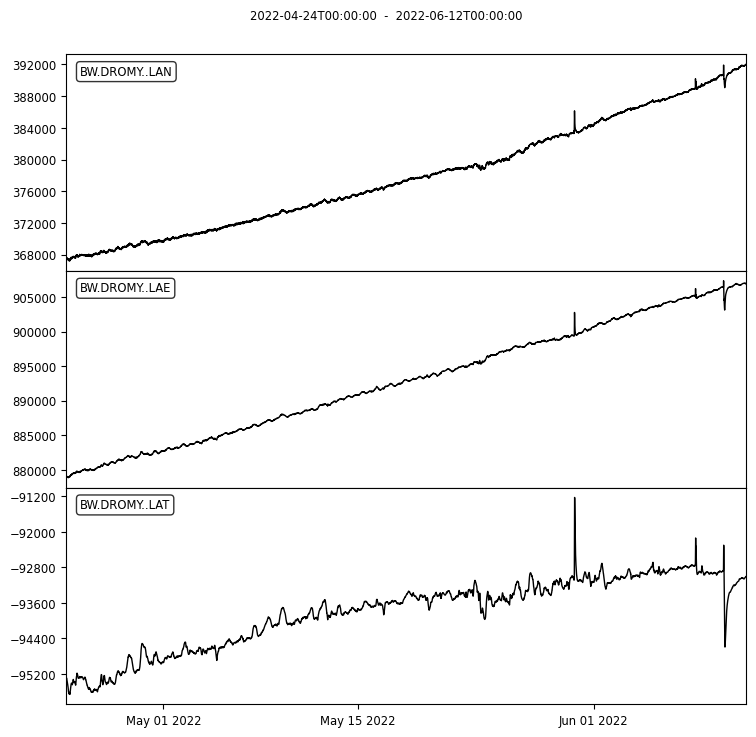

In [13]:
BROMY0 = __load_local(config, "BW.DROMY..LA*")
BROMY0.sort()
print(BROMY0)
BROMY0.plot(equal_scale=False);

### Data Conversion to rad

In [14]:
TROMY = __conversion(TROMY0, confTilt['TROMY'])
ROMYT = __conversion(ROMYT0, confTilt['ROMYT'])
BROMY = __conversion(BROMY0, confTilt['BROMY'])

  -> converted data of TROMY
  -> converted data of ROMYT
  -> converted data of DROMY


### Reset Tilt at Start

In [15]:
## Reset start to Zero
for st in [TROMY, ROMYT, BROMY]:
    for tr in st:
        if not tr.stats.channel[-1] == "T" or tr.stats.channel[0] == "W":
            tr.data -= tr.data[1]

In [16]:
def __plot_all_tilt(st1, st2, st3):

    from datetime import datetime
    
    NN=3
    
    fig, ax = plt.subplots(NN,1, figsize=(15,8), sharex=True)

    font = 14
    
    tilt_scaling, tilt_unit = 1e-6, r"$\mu$rad"
    time_scaling, time_unit = 86400, "days"
    
    ax[0].plot(st1.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*N")[0].data/tilt_scaling, label="TROMY")
    ax[0].plot(st2.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*N")[0].data/tilt_scaling, label="ROMYT")
    ax[0].plot(st3.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*N")[0].data/tilt_scaling, label="BROMY")

    ax[1].plot(st1.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st2.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st3.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*E")[0].data/tilt_scaling)

    ax[2].plot(st1.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*T")[0].data)
    ax[2].plot(st2.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*T")[0].data)
    ax[2].plot(st3.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*T")[0].data)

    ax[0].set_ylabel(f"N ({tilt_unit})", fontsize=font)
    ax[1].set_ylabel(f"E ({tilt_unit})", fontsize=font)
    ax[2].set_ylabel(f"T (°C)", fontsize=font)
#     ax[2].set_xlabel(f"Time ({time_unit})", fontsize=font)
    
    for o in range(3):
        ax[o].grid()
    
    ax[0].legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.7, 1.1), ncol=3, framealpha=1)
    
    tcks= ax[NN-1].get_xticks()
    tcklbls = [datetime.fromtimestamp(t*time_scaling+datetime(2019,1,1).timestamp()).strftime("%Y-%m-%d") for t in tcks]
    ax[NN-1].set_xticklabels(tcklbls)
    
    plt.show();
    return fig

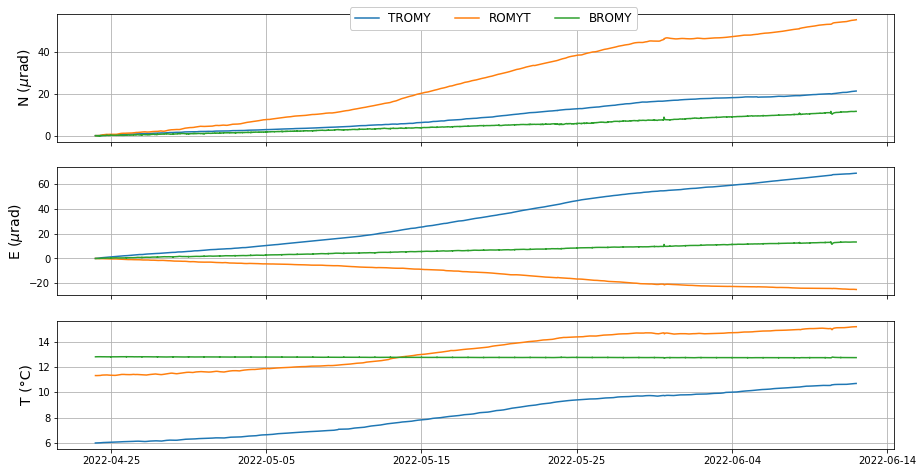

In [17]:
fig = __plot_all_tilt(TROMY, ROMYT, BROMY)   

### Correct for linear temperature effect on components

In [18]:
def __correct_temperature_trend(st, correction):
    
    st0 = st.copy()
    temperature = st0.select(channel="*T")[0].data
    
#     st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature + correction['N_intercept'])
#     st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature + correction['N_intercept'])
    st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature)
    st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature)
    
    return st0

In [19]:
## load correction model
# temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","temperature_correction.yml")

## apply correction model
TROMY = __correct_temperature_trend(TROMY, temperature_correction['TROMY'])
ROMYT = __correct_temperature_trend(ROMYT, temperature_correction['ROMYT'])
BROMY = __correct_temperature_trend(BROMY, temperature_correction['BROMY'])

In [20]:
## Reset start to Zero
for st in [TROMY, ROMYT, BROMY]:
    for tr in st:
        if not tr.stats.channel[-1] == "T" or tr.stats.channel[0] == "W":
            tr.data -= tr.data[1]

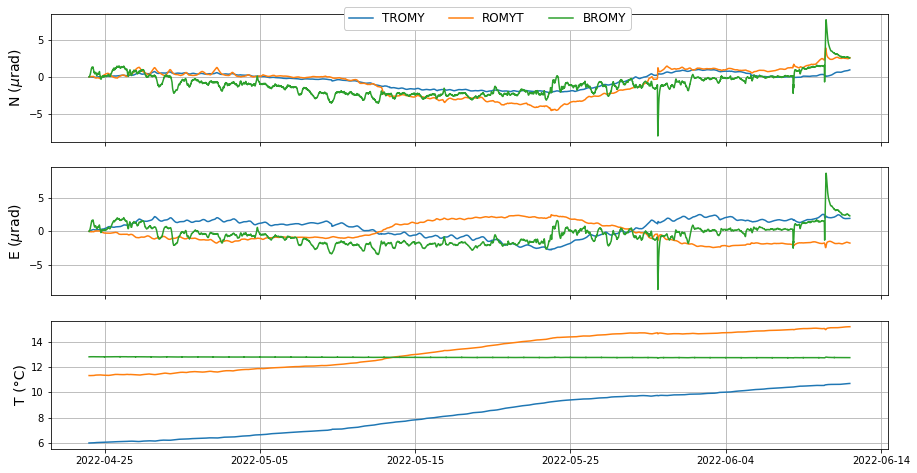

In [21]:
fig = __plot_all_tilt(TROMY, ROMYT, BROMY)   

### Manipulate Components

In [22]:
## change polarity of Channel
# TRII.select(channel="*E")[0].data *= -1

## exchange N and E
# TRII.select(channel="*E")[0].stats.channel = "MAP"
# TRII.select(channel="*N")[0].stats.channel = "MAE"
# TRII.select(channel="*P")[0].stats.channel = "MAN"

# fig = __makeplot(TROMY, TRII, config);